In [9]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the delta_CDR for 
# the single application versus multiple rock
# application scenarios
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# set data path
datpath = "/home/tykukla/ew-workflows/scripts/scepter/process/runs/batch_postproc_tmp/cc-sil_psize_apprate"

# --- select which data to read in 
# SINGLE APPLICATION
fertLevel_1 = "low"
idx_1 = "001"
tag_sil_1 = "base_psdfull_singleapp"

# MULTIPLE APPLICATIONS
fertLevel_2 = "low"
idx_2 = "001"
tag_sil_2 = "base_psdfull"



In [10]:
# ---- READ IN DATA
# SINGLE APPLICATION
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# MULTIPLE APPLICATIONS
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))

In [11]:
dssil1

<xarray.Dataset> Size: 1MB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 20,
                                   dustrad: 19)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 160B 0.007 ......
  * dustrad                       (dustrad) int32 76B 1 3 6 10 ... 200 250 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 152kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

In [12]:
# update single app coords to account for single app
dur_multiapp = 15.  # years of repeated application in the multi app case
dssil1 = dssil1.assign_coords(dustrate_ton_ha_yr=dssil1.coords['dustrate_ton_ha_yr'] * dur_multiapp)
dscc1 = dscc1.assign_coords(dustrate_ton_ha_yr=dscc1.coords['dustrate_ton_ha_yr'] * dur_multiapp)

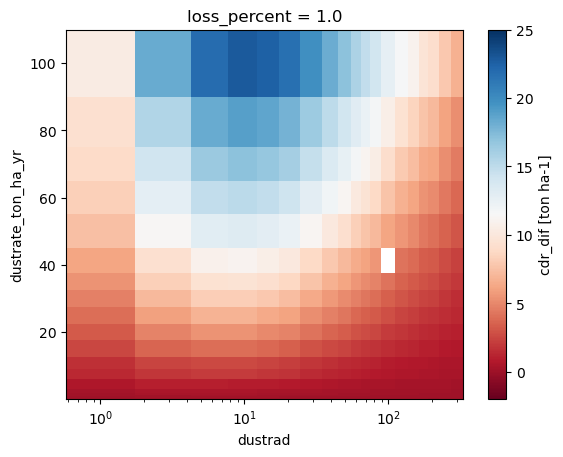

In [13]:
# sil compare
dssil1_ex = dssil1.sel(loss_percent = 1, method='nearest')['cdr_dif'].transpose()
dssil2_ex = dssil2.sel(loss_percent = 1, method='nearest')['cdr_dif'].transpose()

# (dssil2_ex - dssil1_ex).plot(xscale='log')
dssil1_ex.plot(cmap='RdBu', vmin=-2, vmax=25, xscale='log')

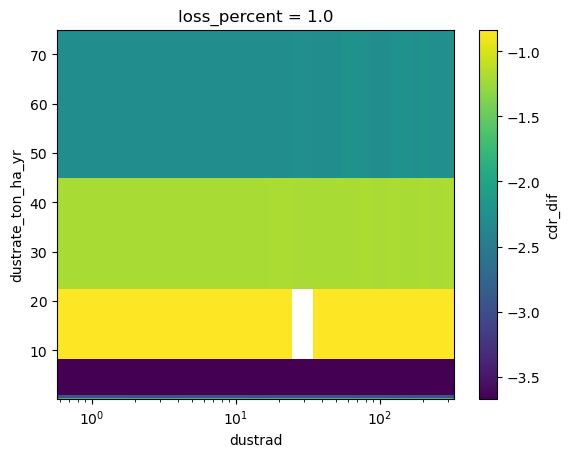

In [14]:
# cc compare
dscc1_ex = dscc1.sel(loss_percent = 1, method='nearest')['cdr_dif'].transpose()
dscc2_ex = dscc2.sel(loss_percent = 1, method='nearest')['cdr_dif'].transpose()

(dscc1_ex - dscc2_ex).plot(xscale='log')
# dscc2_ex.plot(cmap='RdBu', vmin=-2, vmax=7)

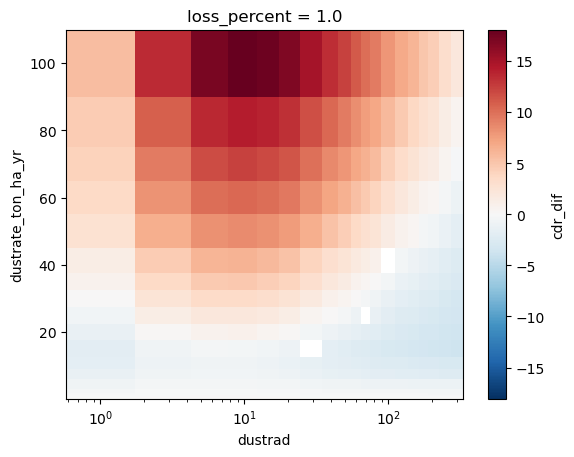

In [15]:
# just single app
(dssil1_ex - dscc1_ex).plot(xscale='log')

## Plot 1:
R_sil - R_cc contour plots -- one for multiple applications and one for single application

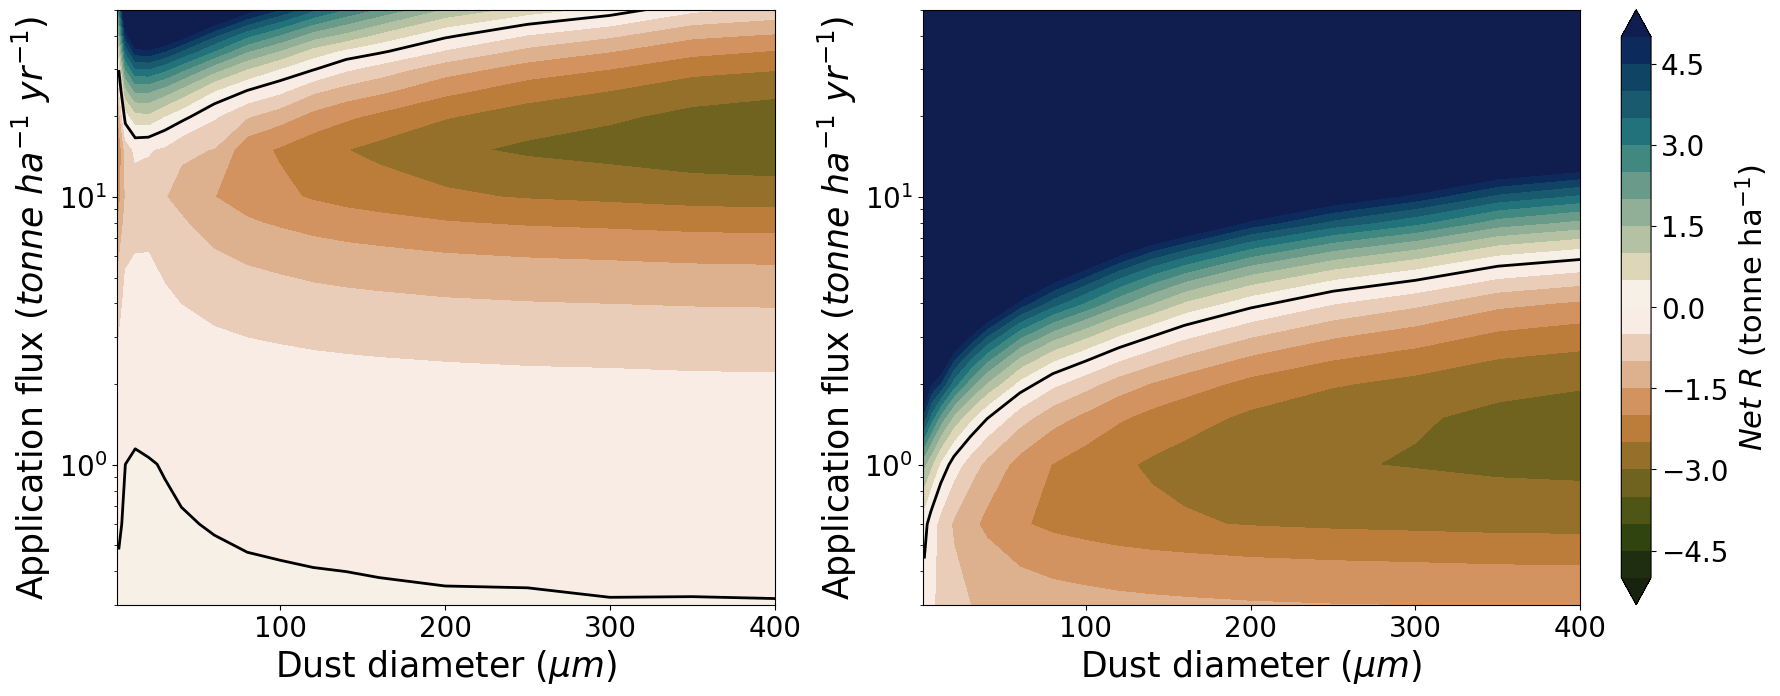

In [16]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 0
cdr_calc = 'netR'
logX = False
logY = True

# pull out the data we want
ds1_p1 = dssil1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_p1 = dscc1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]

ds1_p2 = dssil2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_p2 = dscc2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_p1 = ds1_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p1 = ds2_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

ds1_p2 = ds1_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p2 = ds2_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.tarn
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.3 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = ds1_p1['dustrad'].values
y1 = ds1_p1['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = ds1_p2['dustrad'].values
y2 = ds1_p2['dustrate_ton_ha_yr'].values

# normalize color scale to center at zero
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(21,17))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1, (ds1_p1.transpose() - ds2_p1.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,(ds1_p1.transpose() - ds2_p1.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"single application", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2, (ds1_p2.transpose() - ds2_p2.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,(ds1_p2.transpose() - ds2_p2.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"multiple applications", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$Net\ R\ (\text{tonne}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)


## Plot 1a: 
Removal minus Emissions

In [17]:
dssil1['E_total_tonCO2_ha']

<xarray.DataArray 'E_total_tonCO2_ha' (dustrad: 19, dustrate_ton_ha_yr: 20)> Size: 3kB
[380 values with dtype=float64]
Coordinates:
  * dustrad             (dustrad) int32 76B 1 3 6 10 15 ... 150 175 200 250 300
  * dustrate_ton_ha_yr  (dustrate_ton_ha_yr) float64 160B 0.105 0.3 ... 100.0
Attributes:
    cdr_fxn:  rockdiss

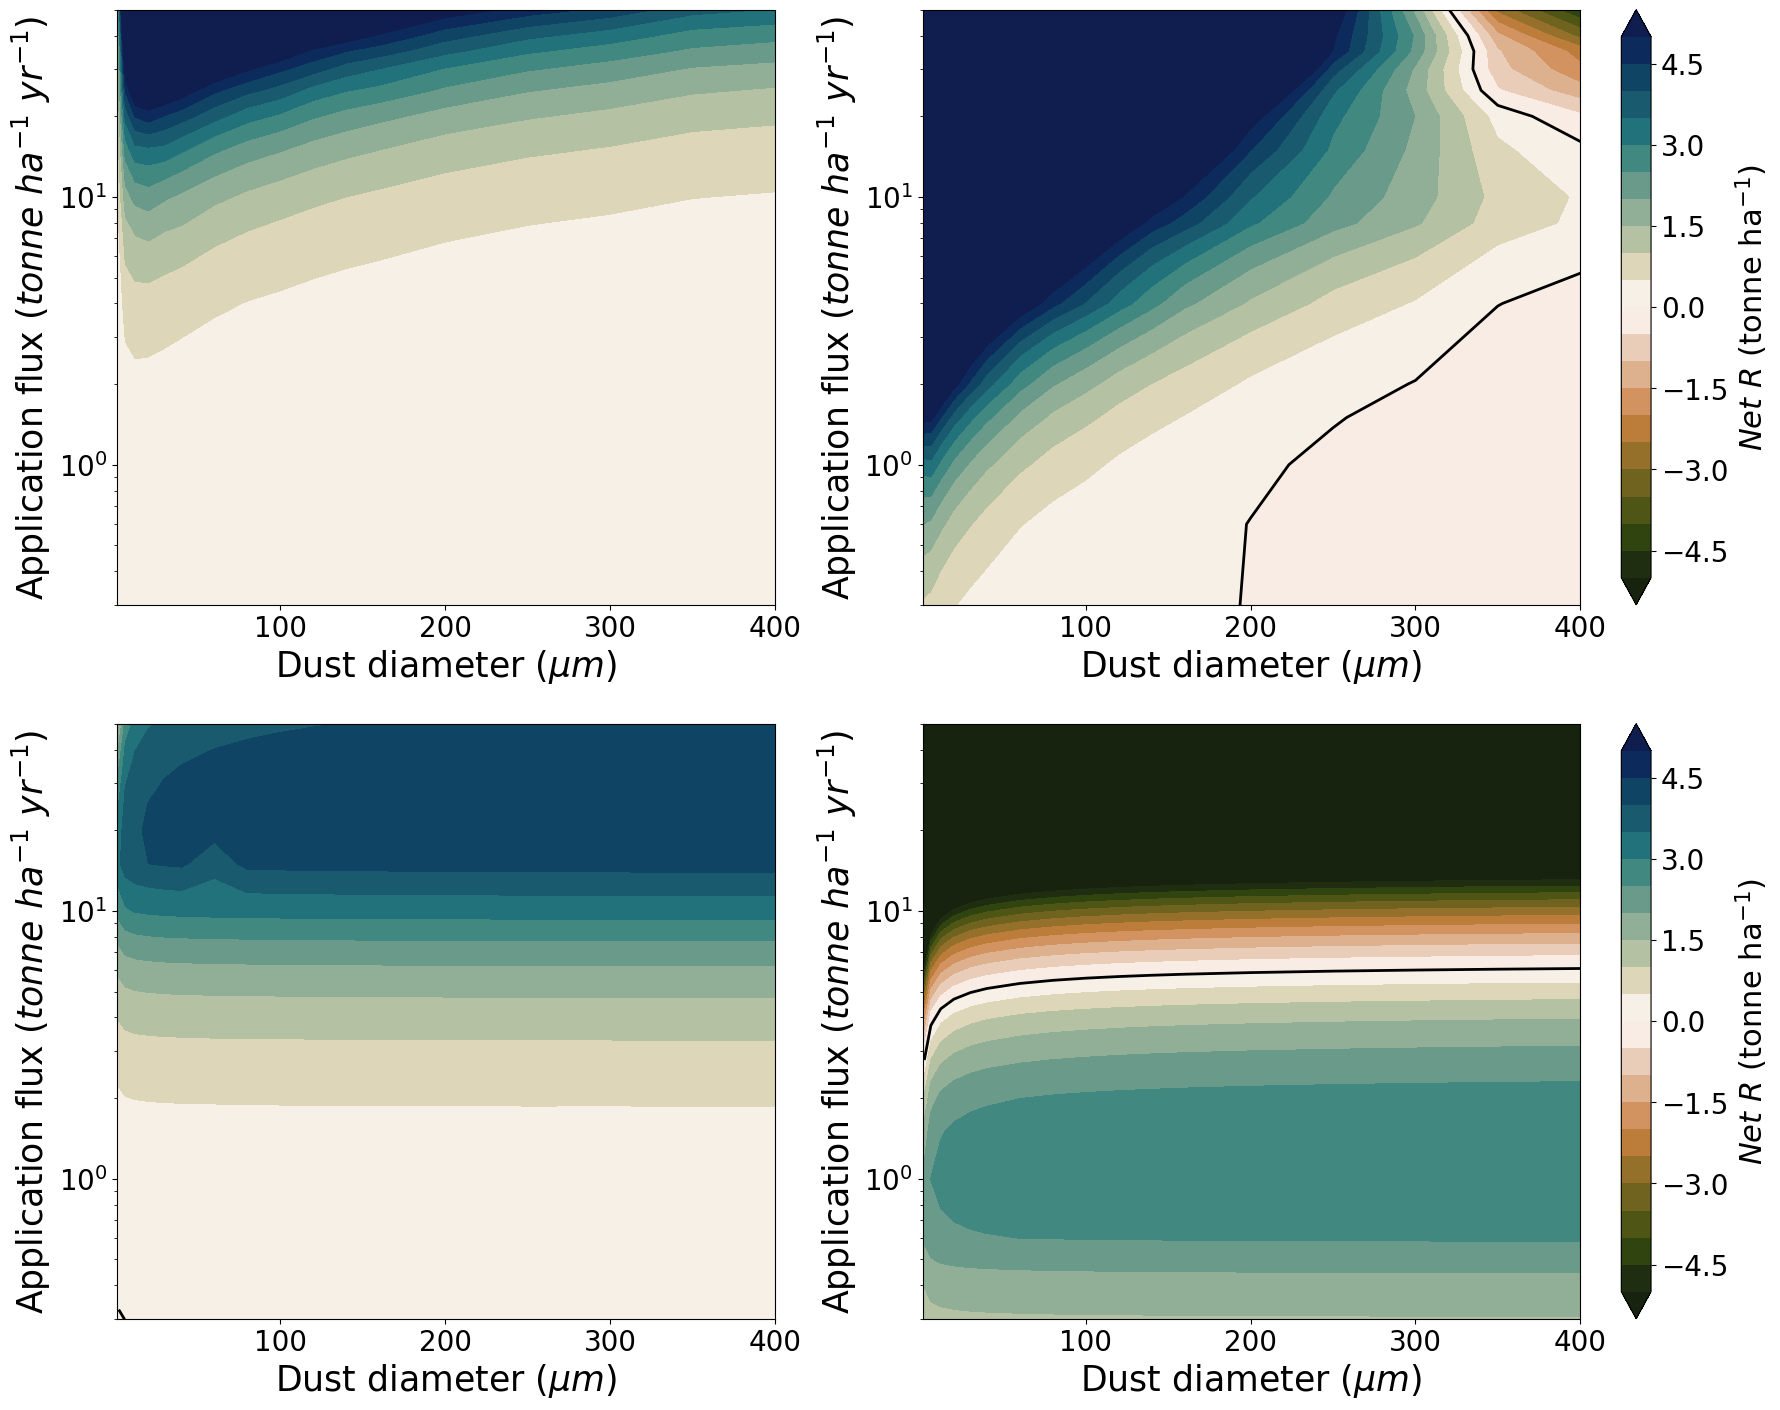

In [21]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
E_var = 'E_total_tonCO2_ha'
loss_percent = 0
logX = False
logY = True

# pull out the data we want
# [ carbonate - removal ]
dsccR_p1 = dscc1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsccR_p2 = dscc2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [ carbonate - emissions ]
dsccE_p1 = dscc1.sel(loss_percent=loss_percent, method='nearest')[E_var]
dsccE_p2 = dscc2.sel(loss_percent=loss_percent, method='nearest')[E_var]

# [ silicate - removal ]
dssilR_p1 = dssil1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dssilR_p2 = dssil2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# [ silicate - emissions ]
dssilE_p1 = dssil1.sel(loss_percent=loss_percent, method='nearest')[E_var]
dssilE_p2 = dssil2.sel(loss_percent=loss_percent, method='nearest')[E_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
# [ carbonate - removal ]
dsccR_p1 = dsccR_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsccR_p2 = dsccR_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# [ carbonate - emissions ]
dsccE_p1 = dsccE_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsccE_p2 = dsccE_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# [ silicate - removal ]
dssilR_p1 = dssilR_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssilR_p2 = dssilR_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# [ silicate - emissions ]
dssilE_p1 = dssilE_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssilE_p2 = dssilE_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()



# *****************************
# --- plot aesthetics
# color palette
col = cmo.tarn
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.3 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dssilR_p1['dustrad'].values
y1 = dssilR_p1['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = dssilR_p2['dustrad'].values
y2 = dssilR_p2['dustrate_ton_ha_yr'].values

# normalize color scale to center at zero
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(21,17))

# --- single-app | sil
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1, (dssilR_p1.transpose() - dssilE_p1.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,(dssilR_p1.transpose() - dssilE_p1.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"single application", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- annual app | sil
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2, (dssilR_p2.transpose() - dssilE_p2.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,(dssilR_p2.transpose() - dssilE_p2.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"multiple applications", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$Net\ R\ (\text{tonne}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)

# --- single-app | cc
ax = plt.subplot(spec[2])
contour = plt.contourf(x1*2,y1, (dsccR_p1.transpose() - dsccE_p1.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,(dsccR_p1.transpose() - dsccE_p1.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"single application", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- annual app | cc
ax = plt.subplot(spec[3])
contour = plt.contourf(x2*2,y2, (dsccR_p2.transpose() - dsccE_p2.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,(dsccR_p2.transpose() - dsccE_p2.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"Application flux $(tonne\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"multiple applications", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$Net\ R\ (\text{tonne}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)


## Plot 2:
Fraction of rock dissolved for single and multiple applications

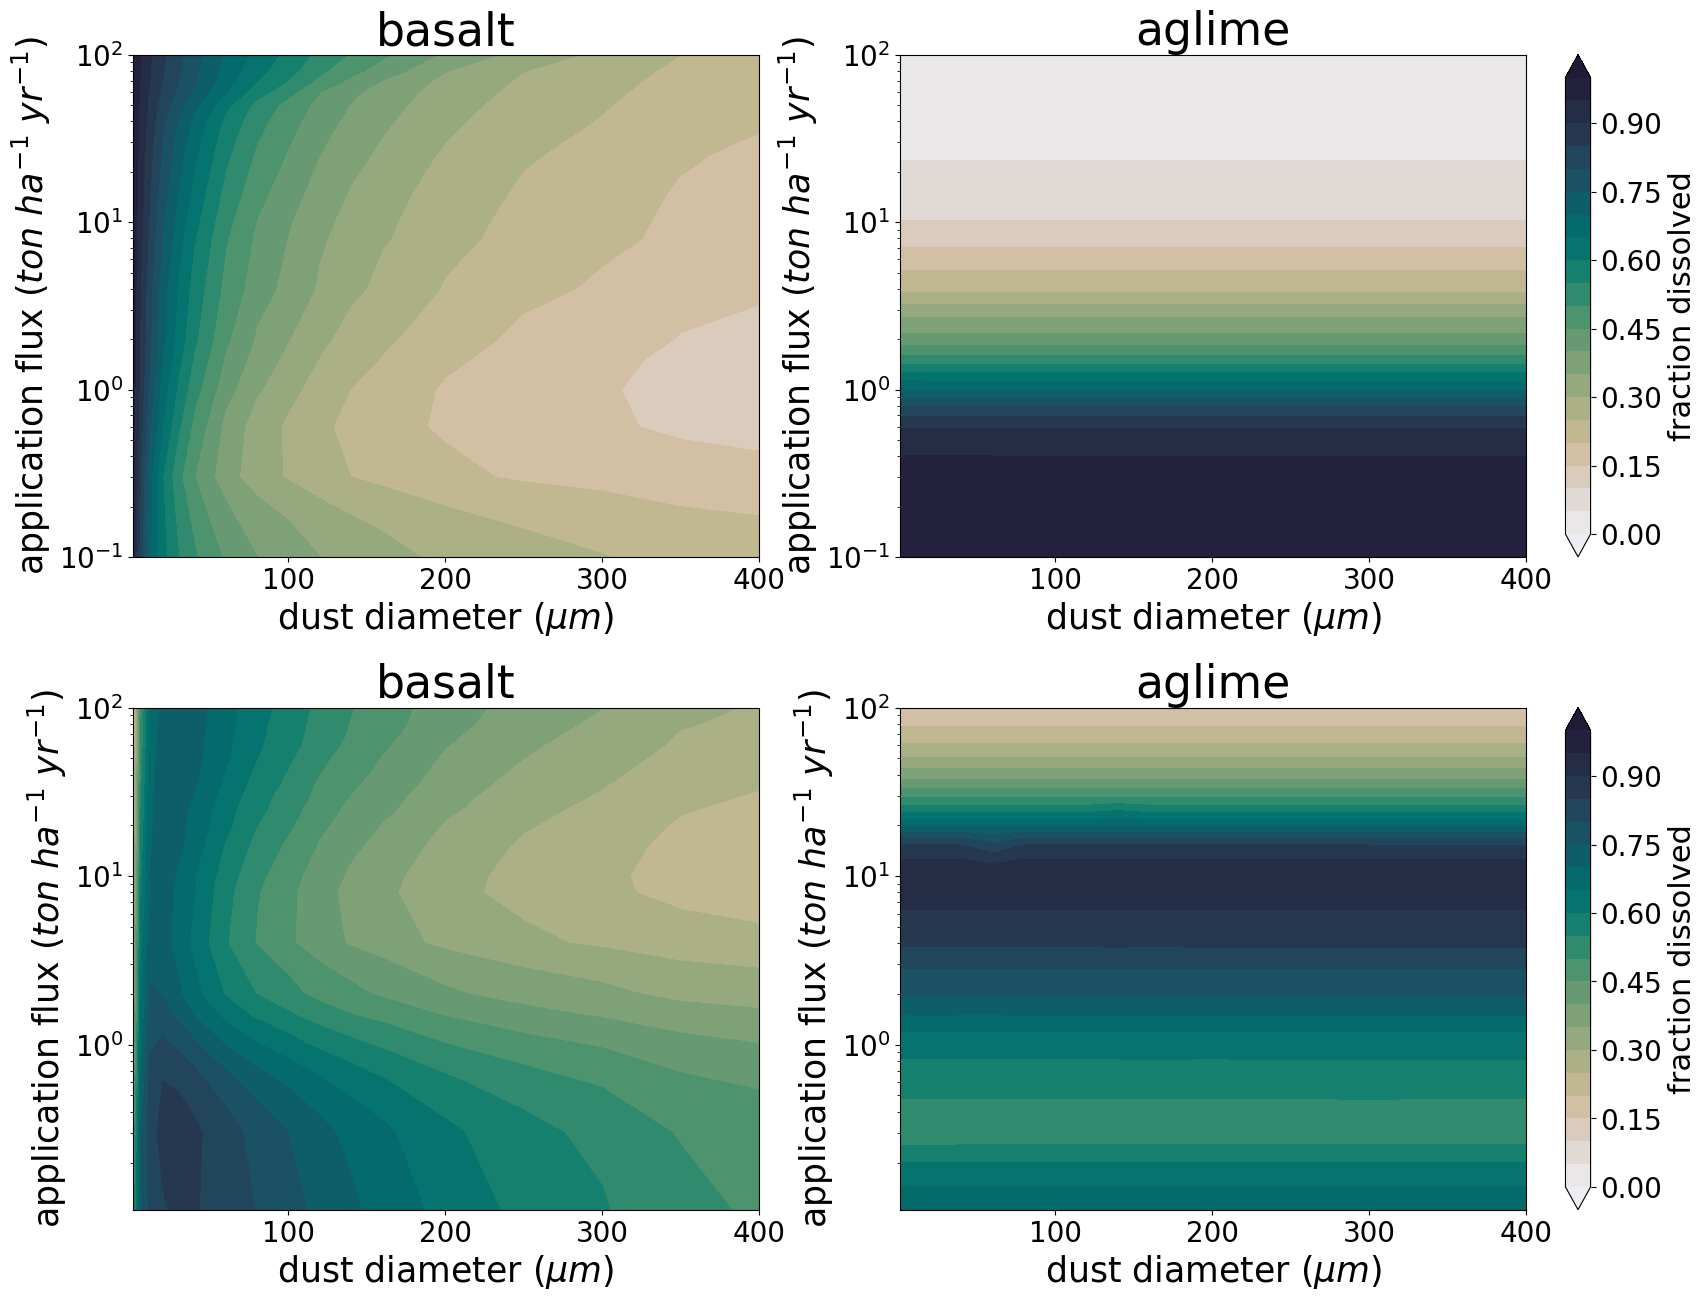

In [10]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'fraction_remaining_dissolved'
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12]
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.rain
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0, 1.0
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

## Plot X: initial removal for aglime and basalt for single and multi-year applications

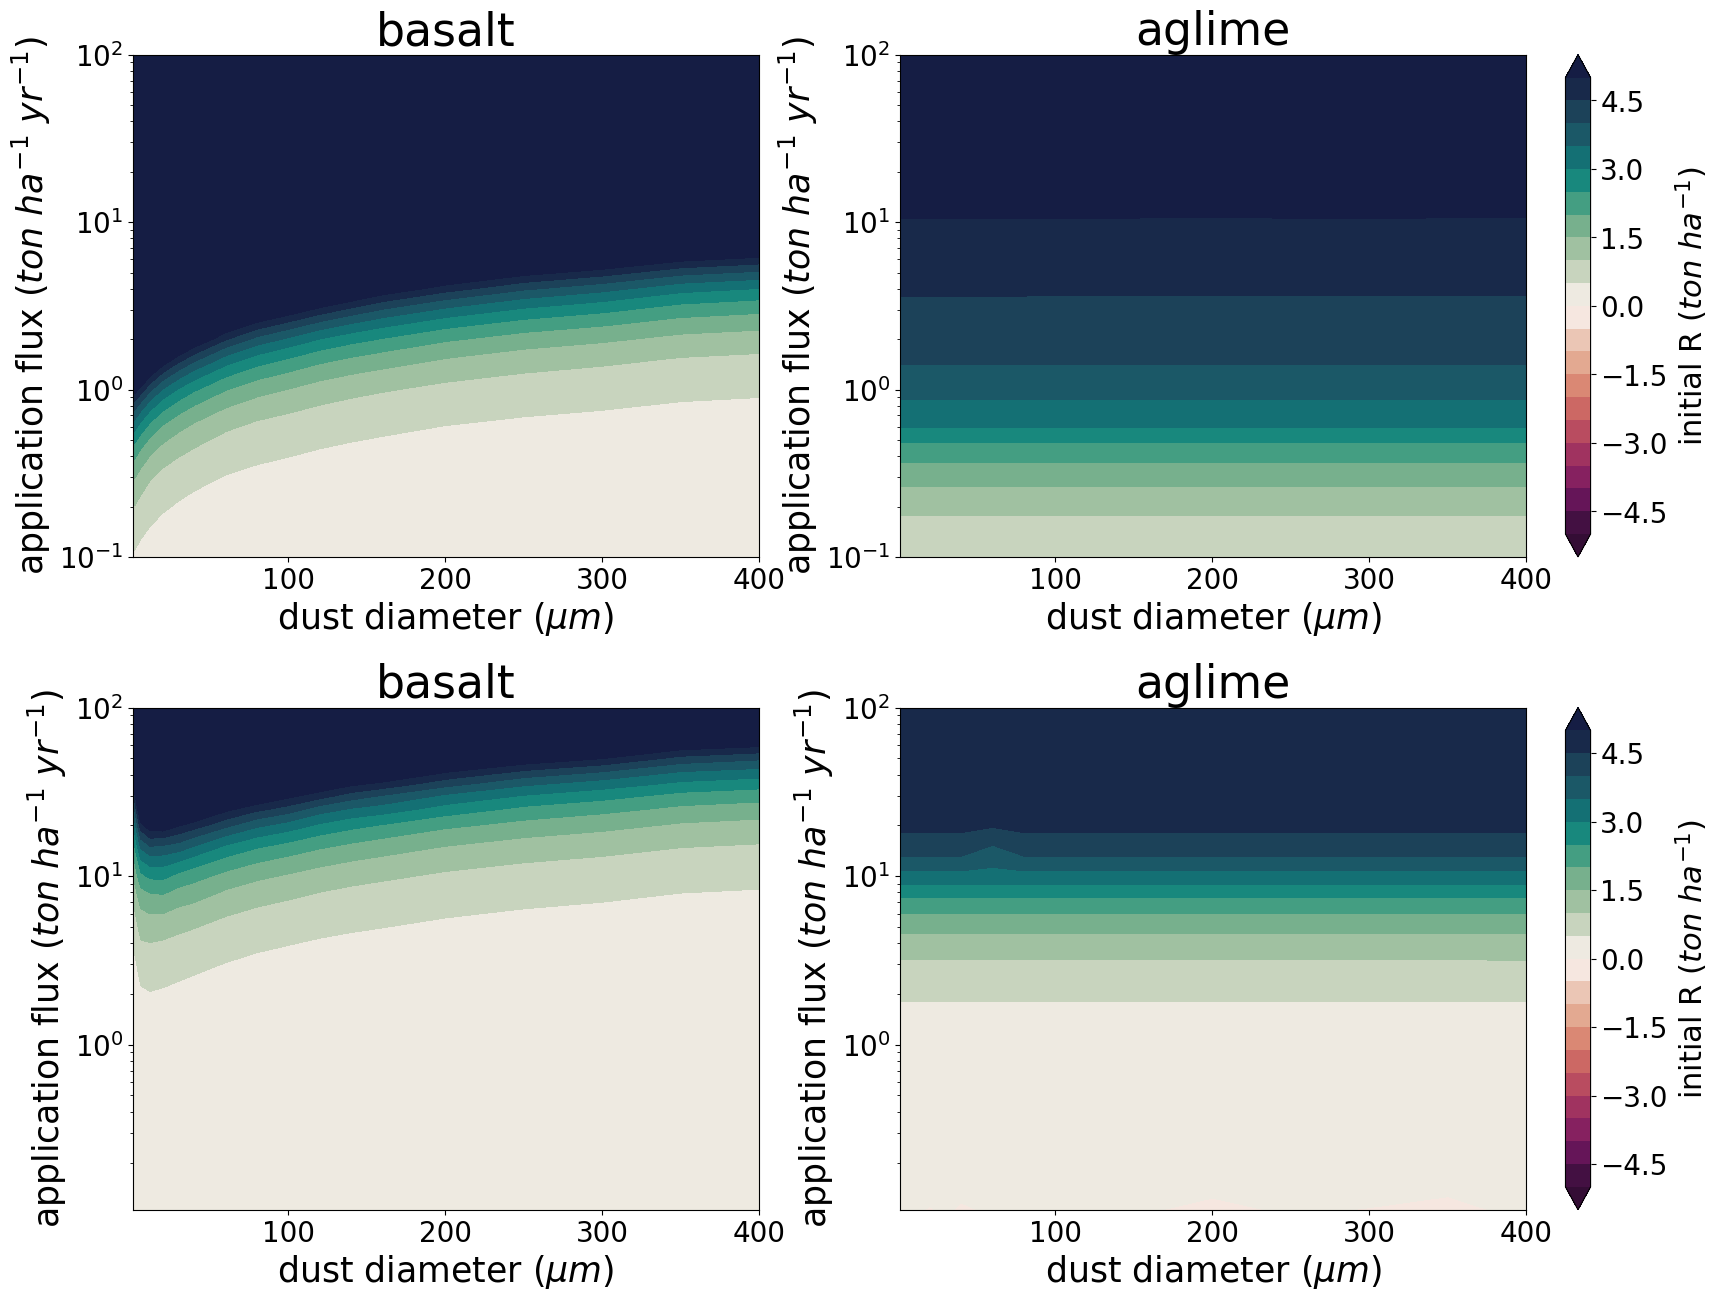

In [12]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12]
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

In [38]:
dssil1

<xarray.Dataset> Size: 405kB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 13,
                                   dustrad: 9)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 104B 0.3 ... 1...
  * dustrad                       (dustrad) int32 36B 1 10 30 50 ... 125 150 200
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 47kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

## Plot 3:
Fraction of rock dust advected out of the bottom of the column...

This is a LOT of advected dust!! what's going on here? 

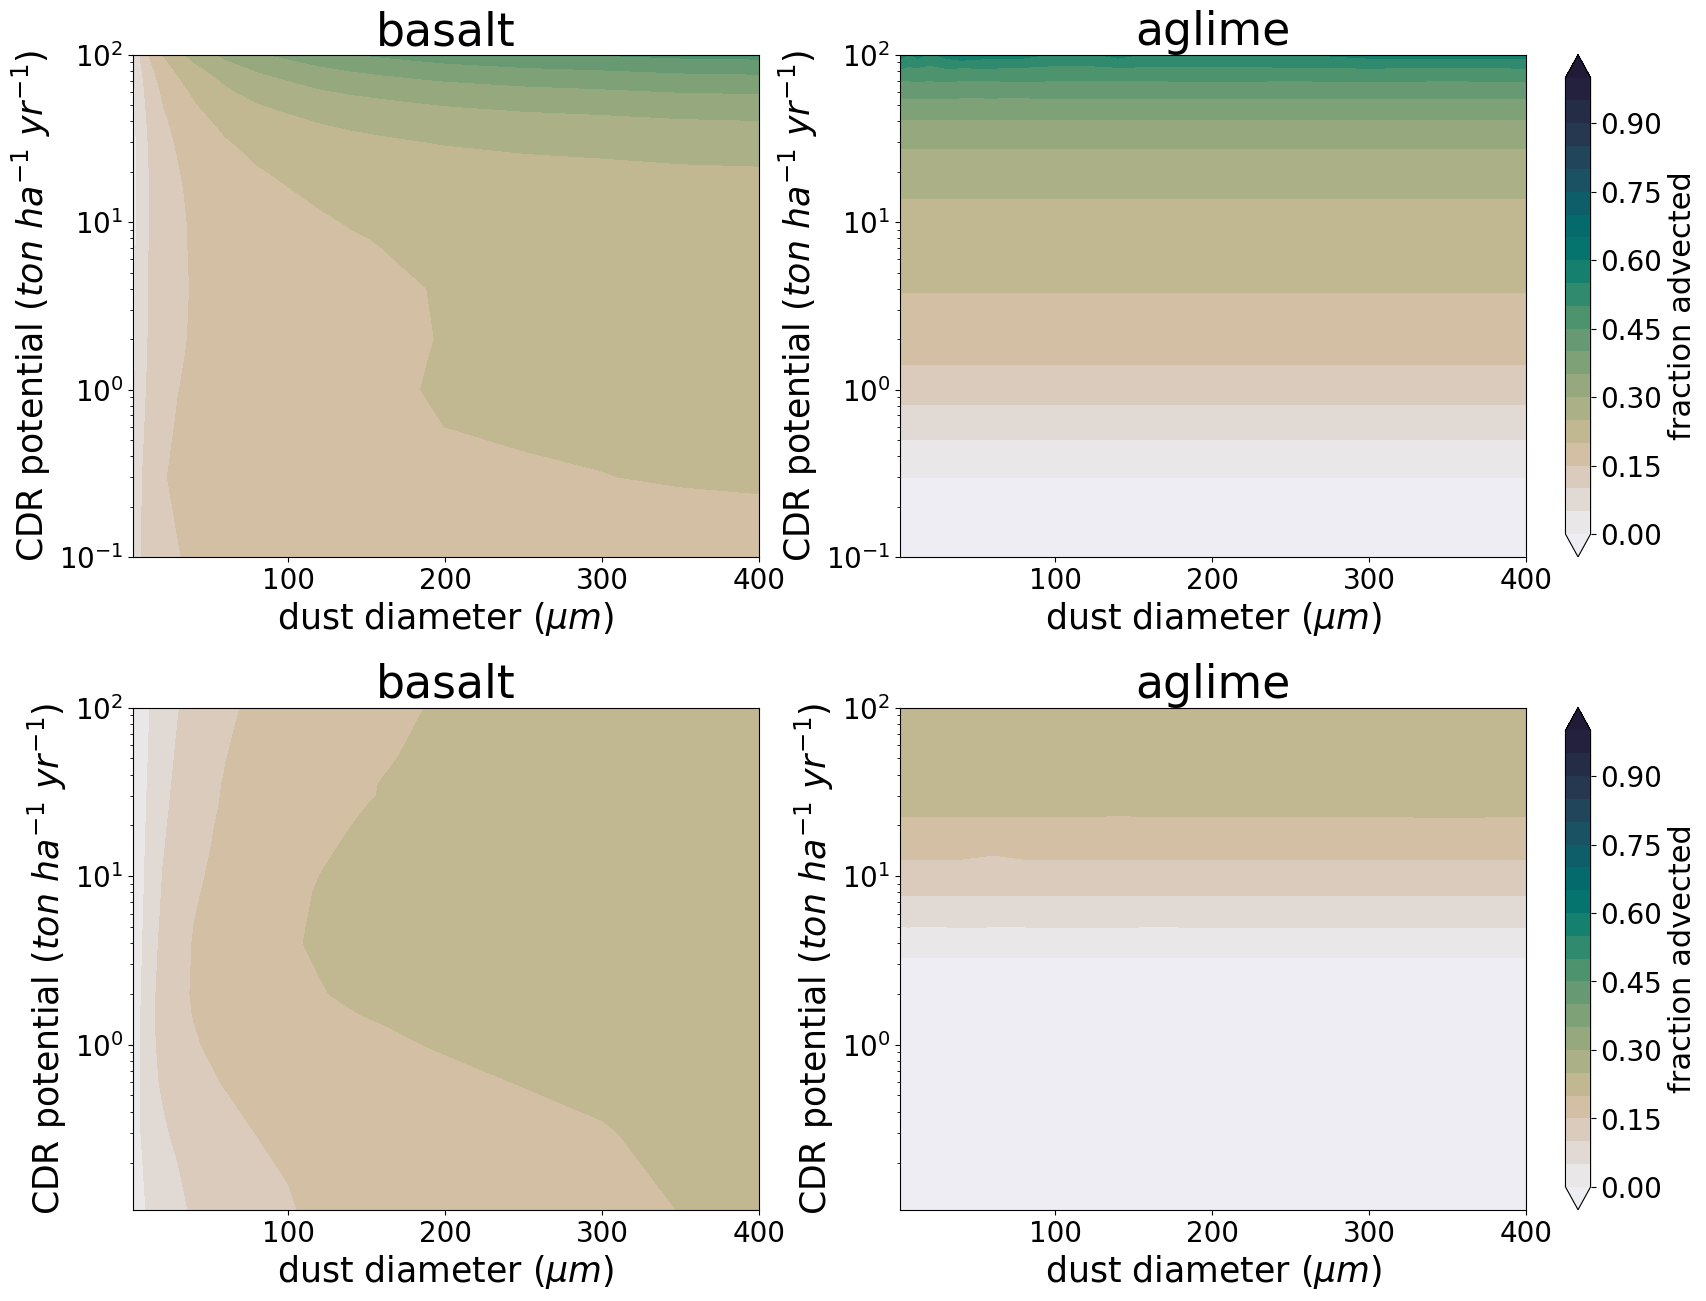

In [13]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'fraction_sld_advected'
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12]
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.rain
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0, 1.0
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction advected", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction advected", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

In [ ]:
# --------------------